In [2]:
import sys

sys.path.append('../')
sys.path.append('../my_libs/')
sys.path.append('../my_libs/img/')

!{sys.executable} -m pip install -r ../../pip-dependencies.txt

Defaulting to user installation because normal site-packages is not writeable


In [7]:
import my_libs as ml
from my_libs.tools import *
from my_libs.fft import *
from my_libs.colors import *
from my_libs.img import images
from my_libs.img.processing import *

In [4]:
ml.tools.printf("Hello world!")

Hello world!

## Cvičení 11

In [5]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

Naprogramujte  algoritmus  MACE.  Pro  trénování  (3  různí  lidé)  použijte obrázky (převedené do stupňů šedi) p11...p33.bmp (PVI_C11.ZIP). 
 
Pomocí  algoritmu  MACE  klasifikujte  neznámý  obraz  `unknown.bmp`. Strmost vrcholu ve výsledném obraze počítejte ze střední oblasti 20x20 ve které je vrchol v oblasti 10x10. 
 
Vykreslete  (v  jednom  okně)  neznámý  obrázek  a  jeden  z  obrázků klasifikované třídy. 

In [6]:
vec = np.fft.fft2(imG).flatten()
#np.fft.fft2(imG).flatten().reshape(4096,1) 
 
X = np.zeros((4096,3),dtype=complex) 
 
Xp = X.conjugate().transpose() 
 
Dm1 = np.linalg.inv(D) 
 
M0 = np.matmul(Dm1, X) 
 
A = np.abs(np.fft.ifft2(M)) 

NameError: name 'imG' is not defined

In [17]:
folder = 'data/'
uknown_file = 'unknown.bmp'

# Filter images
picture_files = images.find(folder, "bmp")
picture_files.sort()

for i in range(len(picture_files)):
    if picture_files[i].find(uknown_file) != -1:
        picture_files.pop(i)
        break

number_of_images = len(picture_files)
print("Number of images: ", number_of_images)

# Load images
imgs = images.load(picture_files)

Current working directory: /home/pytel/Skola/TUL-navazující_studium/3. semestr/PVI-Pocitacove_videni/cviceni/cv11, files: 
p11.bmp
p21.bmp
p31.bmp
p12.bmp
p33.bmp
p22.bmp
p23.bmp
p32.bmp
unknown.bmp
p13.bmp
Number of images:  9


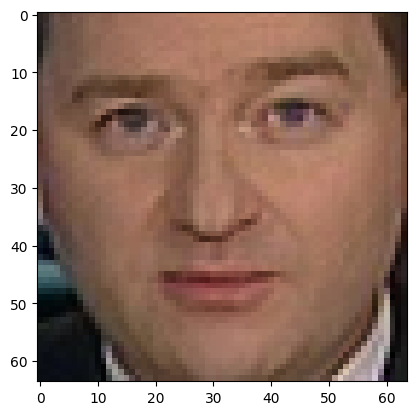

In [19]:
# Show unknown image
path = folder + uknown_file

# test if exists
if not os.path.exists(path):
    raise Exception("File not found: " + path)

unknown_image_bgr = cv.imread(folder + uknown_file)
unknown_image = cv.cvtColor(unknown_image_bgr, cv.COLOR_BGR2RGB)

plt.imshow(unknown_image)